# Truth Social Analytics Notebook
---
This Jupyter notebook provides a user-friendly interface to the Truthbrush CLI tool, allowing you to easily collect and analyze data from Truth Social. This tool enables researchers, analysts, and journalists to collect data from Truth Social without manual scraping,
transform raw API responses into clean pandas DataFrames, and provide an environment to visualize potential patterns in behavior or content spread.

This jupyter and pandas enviornment allows you to easily save API responses in the format of your choice; I'd recommend using parquet format.

In [1]:
import json
import subprocess
import os
import pandas as pd
from datetime import datetime
import io
from IPython.display import display, HTML

### Set Up

In [2]:
# Set your credentials here (or set them as environment variables before starting Jupyter)
def set_credentials(username=None, password=None, token=None):
    """Set Truth Social credentials for API access"""
    if token:
        os.environ["TRUTHSOCIAL_TOKEN"] = token
        print("Token set successfully.")
        return
    
    if username and password:
        os.environ["TRUTHSOCIAL_USERNAME"] = username
        os.environ["TRUTHSOCIAL_PASSWORD"] = password
        print("Username and password set successfully.")
        return
    
    print("Please provide either a token or both username and password.")

In [ ]:
# Uncomment to configure within this environment:
# set_credentials(username="your_username", password="your_password")
# or
# set_credentials(token="your_token")

## Helper Functions

In [3]:
def run_command(command):
    """Run a Truthbrush CLI command and return the result as JSON"""
    try:
        result = subprocess.run(command, capture_output=True, text=True, check=True)
        # Handle multiple JSON objects by splitting on newlines
        output_lines = result.stdout.strip().split('\n')
        json_results = []
        
        for line in output_lines:
            if line:  # Skip empty lines
                try:
                    json_results.append(json.loads(line))
                except json.JSONDecodeError:
                    print(f"Warning: Could not parse line as JSON: {line}")
        
        if len(json_results) == 1:
            return json_results[0]
        return json_results
    except subprocess.CalledProcessError as e:
        print(f"Error executing command: {e}")
        print(f"STDERR: {e.stderr}")
        return None

def json_to_df(json_data):
    """Convert JSON data to a pandas DataFrame"""
    if isinstance(json_data, list):
        # If it's already a list of records
        return pd.DataFrame(json_data)
    elif isinstance(json_data, dict):
        # If it's a dictionary, check if values are lists or primitives
        for key, value in json_data.items():
            if isinstance(value, list) and len(value) > 0:
                return pd.DataFrame(value)
        # If no list values found, treat the dict as a single record
        return pd.DataFrame([json_data])
    else:
        print(f"Unsupported data type: {type(json_data)}")
        return pd.DataFrame()

## Functions
---
### Search

In [4]:
def search_truthsocial(query, searchtype="accounts", limit=40):
    """
    Search Truth Social for users, statuses, hashtags, or groups.
    
    Parameters:
    -----------
    query : str
        The search query
    searchtype : str
        Type of search - one of "accounts", "statuses", "hashtags", or "groups"
    limit : int
        Maximum number of results to return
        
    Returns:
    --------
    pandas.DataFrame
        Search results as a DataFrame
    """
    command = ["truthbrush", "search", query, "--searchtype", searchtype, "--limit", str(limit)]
    results = run_command(command)
    
    if not results:
        return pd.DataFrame()
    
    # Search results might be a list of pages
    if isinstance(results, list):
        # Flatten the list of results
        flattened = []
        for page in results:
            if isinstance(page, list):
                flattened.extend(page)
            else:
                flattened.append(page)
        return pd.DataFrame(flattened)
    
    return json_to_df(results)

#### User Statuses

In [5]:
def get_user_statuses(username, include_replies=False, created_after=None, pinned_only=False):
    """
    Get a user's posts/statuses from Truth Social.
    
    Parameters:
    -----------
    username : str
        The username to retrieve statuses for
    include_replies : bool
        Whether to include replies in the results
    created_after : str or datetime
        Only retrieve statuses created after this date/time (ISO format)
    pinned_only : bool
        Whether to only retrieve pinned statuses
        
    Returns:
    --------
    pandas.DataFrame
        User statuses as a DataFrame
    """
    command = ["truthbrush", "statuses", username]
    
    if include_replies:
        command.append("--replies")
    else:
        command.append("--no-replies")
        
    if created_after:
        if isinstance(created_after, datetime):
            created_after = created_after.isoformat()
        command.extend(["--created-after", created_after])
        
    if pinned_only:
        command.append("--pinned")
    
    results = run_command(command)
    
    if not results:
        return pd.DataFrame()
    
    # Results might be a list of statuses
    if isinstance(results, list):
        return pd.DataFrame(results)
    
    return json_to_df(results)

### User Information

In [6]:
def get_user_info(handle):
    """
    Get a user's profile information from Truth Social.
    
    Parameters:
    -----------
    handle : str
        The username to retrieve information for
        
    Returns:
    --------
    pandas.DataFrame
        User information as a DataFrame
    """
    command = ["truthbrush", "user", handle]
    result = run_command(command)
    
    if not result:
        return pd.DataFrame()
    
    return json_to_df(result)

### Trending Content

In [7]:
def get_trending_truths():
    """
    Get trending Truth posts.
    
    Returns:
    --------
    pandas.DataFrame
        Trending posts as a DataFrame
    """
    command = ["truthbrush", "trends"]
    results = run_command(command)
    
    if not results:
        return pd.DataFrame()
    
    return json_to_df(results)

def get_trending_tags():
    """
    Get trending hashtags on Truth Social.
    
    Returns:
    --------
    pandas.DataFrame
        Trending hashtags as a DataFrame
    """
    command = ["truthbrush", "tags"]
    results = run_command(command)
    
    if not results:
        return pd.DataFrame()
    
    return json_to_df(results)

### Suggested Users

In [8]:
def get_suggested_users():
    """
    Get suggested users to follow from Truth Social.
    
    Returns:
    --------
    pandas.DataFrame
        Suggested users as a DataFrame
    """
    command = ["truthbrush", "suggestions"]
    results = run_command(command)
    
    if not results:
        return pd.DataFrame()
    
    return json_to_df(results)

### Advertisements

In [9]:
def get_ads():
    """
    Get advertisements from Truth Social.
    
    Returns:
    --------
    pandas.DataFrame
        Advertisements as a DataFrame
    """
    command = ["truthbrush", "ads"]
    results = run_command(command)
    
    if not results:
        return pd.DataFrame()
    
    return json_to_df(results)

### Post Interactions

In [10]:
def get_post_likes(post_id, include_all=False, top_num=40):
    """
    Get users who liked a specific post.
    
    Parameters:
    -----------
    post_id : str
        The ID of the post
    include_all : bool
        Whether to include all likes (not just the top)
    top_num : int
        Number of likes to retrieve if include_all is False
        
    Returns:
    --------
    pandas.DataFrame
        Users who liked the post as a DataFrame
    """
    command = ["truthbrush", "likes", post_id, str(top_num)]
    
    if include_all:
        command.append("--includeall")
    
    results = run_command(command)
    
    if not results:
        return pd.DataFrame()
    
    # Results might be a list of users
    if isinstance(results, list):
        return pd.DataFrame(results)
    
    return json_to_df(results)

def get_post_comments(post_id, include_all=False, only_first=False, top_num=40):
    """
    Get comments on a specific post.
    
    Parameters:
    -----------
    post_id : str
        The ID of the post
    include_all : bool
        Whether to include all comments
    only_first : bool
        Whether to only include direct replies to the post
    top_num : int
        Number of comments to retrieve if include_all is False
        
    Returns:
    --------
    pandas.DataFrame
        Comments on the post as a DataFrame
    """
    command = ["truthbrush", "comments", post_id, str(top_num)]
    
    if include_all:
        command.append("--includeall")
    
    if only_first:
        command.append("--onlyfirst")
    
    results = run_command(command)
    
    if not results:
        return pd.DataFrame()
    
    # Results might be a list of comments
    if isinstance(results, list):
        return pd.DataFrame(results)
    
    return json_to_df(results)

### Group-Related Functions

In [11]:
def get_group_posts(group_id, limit=20):
    """
    Get posts from a group's timeline.
    
    Parameters:
    -----------
    group_id : str
        The ID of the group
    limit : int
        Maximum number of posts to retrieve
        
    Returns:
    --------
    pandas.DataFrame
        Group posts as a DataFrame
    """
    command = ["truthbrush", "groupposts", group_id, "--limit", str(limit)]
    results = run_command(command)
    
    if not results:
        return pd.DataFrame()
    
    return json_to_df(results)

def get_trending_groups():
    """
    Get trending groups on Truth Social.
    
    Returns:
    --------
    pandas.DataFrame
        Trending groups as a DataFrame
    """
    command = ["truthbrush", "grouptrends"]
    results = run_command(command)
    
    if not results:
        return pd.DataFrame()
    
    return json_to_df(results)

def get_trending_group_tags():
    """
    Get trending hashtags in groups on Truth Social.
    
    Returns:
    --------
    pandas.DataFrame
        Trending group hashtags as a DataFrame
    """
    command = ["truthbrush", "grouptags"]
    results = run_command(command)
    
    if not results:
        return pd.DataFrame()
    
    return json_to_df(results)

def get_suggested_groups():
    """
    Get suggested groups from Truth Social.
    
    Returns:
    --------
    pandas.DataFrame
        Suggested groups as a DataFrame
    """
    command = ["truthbrush", "groupsuggest"]
    results = run_command(command)
    
    if not results:
        return pd.DataFrame()
    
    return json_to_df(results)

## Data Analysis

In [12]:
# Example: Analyze post content
def analyze_posts(df):
    """Perform basic analysis on posts DataFrame"""
    if df.empty:
        print("No data to analyze")
        return
    
    # Check column names
    print("Available columns:", df.columns.tolist())
    
    # Basic statistics
    if 'replies_count' in df.columns:
        print(f"Average replies: {df['replies_count'].mean():.2f}")
    if 'reblogs_count' in df.columns:
        print(f"Average reblogs: {df['reblogs_count'].mean():.2f}")
    if 'favourites_count' in df.columns:
        print(f"Average favorites: {df['favourites_count'].mean():.2f}")
    
    # Most popular posts
    if 'favourites_count' in df.columns:
        print("\nTop 3 posts by favorites:")
        top_posts = df.sort_values('favourites_count', ascending=False).head(3)
        for _, row in top_posts.iterrows():
            print(f"- {row.get('content', '').strip()[:100]}... ({row.get('favourites_count')} favorites)")
    
    # Time analysis
    if 'created_at' in df.columns:
        df['created_at'] = pd.to_datetime(df['created_at'])
        df['hour'] = df['created_at'].dt.hour
        
        print("\nPosts by hour of day:")
        hour_counts = df['hour'].value_counts().sort_index()
        for hour, count in hour_counts.items():
            print(f"{hour:02d}:00 - {hour:02d}:59: {count} posts")

In [13]:
# DEMO:
posts_df = get_user_statuses("ProudBoysStatenIsland", include_replies=True)
posts_df.to_parquet("ProudBoysStatenIsland.parquet")
analyze_posts(posts_df)

Available columns: ['id', 'created_at', 'in_reply_to_id', 'quote_id', 'in_reply_to_account_id', 'sensitive', 'spoiler_text', 'visibility', 'language', 'uri', 'url', 'content', 'account', 'media_attachments', 'mentions', 'tags', 'card', 'group', 'quote', 'in_reply_to', 'reblog', 'sponsored', 'replies_count', 'reblogs_count', 'favourites_count', 'reaction', 'upvotes_count', 'downvotes_count', 'favourited', 'reblogged', 'muted', 'pinned', 'bookmarked', 'poll', 'emojis', 'votable', '_pulled']
Average replies: 1.79
Average reblogs: 7.19
Average favorites: 16.06

Top 3 posts by favorites:
- <p>Please Pray for our Brother. 🙏 We need him home.  His baby girl needs him more than anyone.  If y... (323 favorites)
- <p></p>... (251 favorites)
- <p></p>... (202 favorites)

Posts by hour of day:
00:00 - 00:59: 35 posts
01:00 - 01:59: 30 posts
02:00 - 02:59: 32 posts
03:00 - 03:59: 15 posts
04:00 - 04:59: 14 posts
05:00 - 05:59: 7 posts
06:00 - 06:59: 3 posts
07:00 - 07:59: 1 posts
11:00 - 11:59: 3 p

## Helper Functions for Visualization

In [14]:
def plot_engagement_metrics(df):
    """Create a bar chart of engagement metrics for posts"""
    if df.empty:
        print("No data to visualize")
        return
    
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        # Check if necessary columns exist
        engagement_cols = ['replies_count', 'reblogs_count', 'favourites_count']
        available_cols = [col for col in engagement_cols if col in df.columns]
        
        if not available_cols:
            print("No engagement metrics found in the DataFrame")
            return
        
        # Create a new DataFrame for plotting
        plot_df = df[available_cols].sum().reset_index()
        plot_df.columns = ['Metric', 'Count']
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Metric', y='Count', data=plot_df)
        plt.title('Total Engagement Metrics')
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
    except ImportError:
        print("Please install matplotlib and seaborn to use this function")

def plot_posting_time_distribution(df):
    """Create a histogram of posting times"""
    if df.empty:
        print("No data to visualize")
        return
    
    if 'created_at' not in df.columns:
        print("No 'created_at' column found in the DataFrame")
        return
    
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        # Convert to datetime if needed
        df['created_at'] = pd.to_datetime(df['created_at'])
        
        # Extract hour of day
        df['hour'] = df['created_at'].dt.hour
        
        plt.figure(figsize=(12, 6))
        sns.histplot(data=df, x='hour', bins=24, discrete=True)
        plt.title('Distribution of Posts by Hour of Day')
        plt.xlabel('Hour of Day (24-hour format)')
        plt.ylabel('Number of Posts')
        plt.xticks(range(0, 24))
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
    except ImportError:
        print("Please install matplotlib and seaborn to use this function")


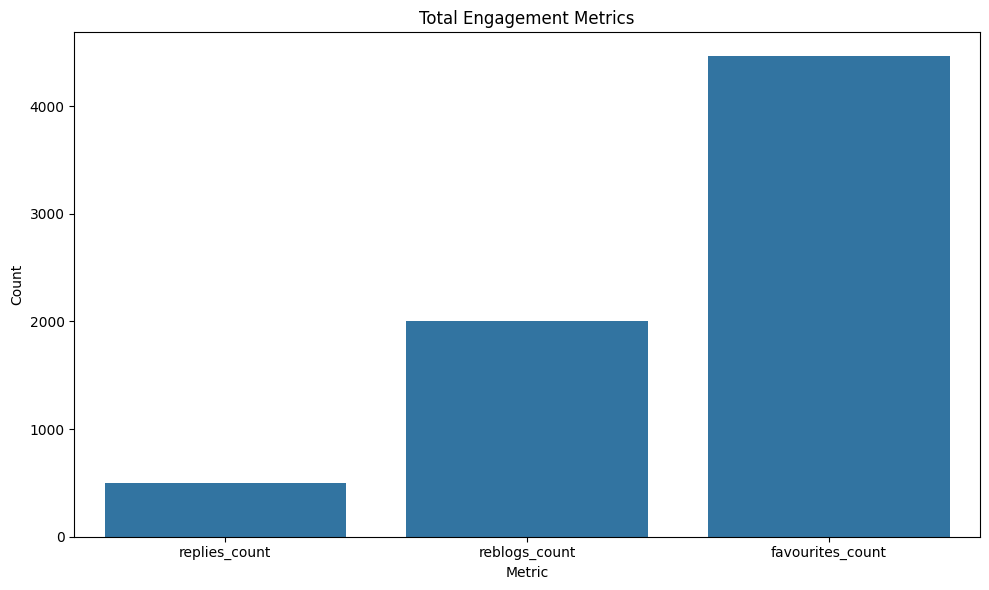

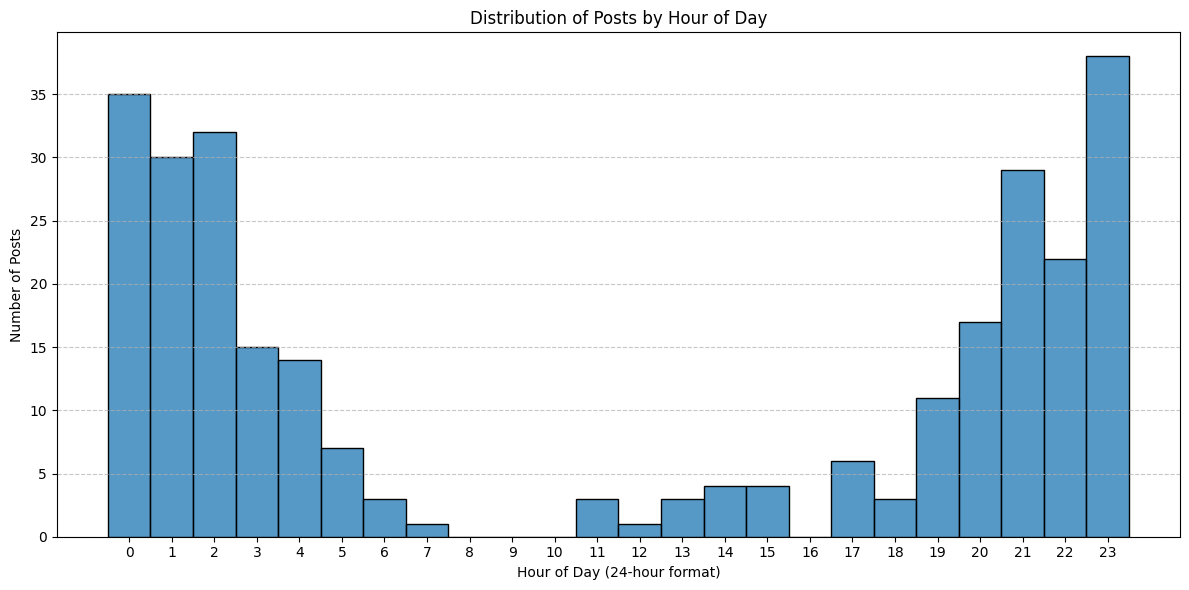

In [15]:
# DEMO:
# posts_df = get_user_statuses("ProudBoysStatenIsland", include_replies=True)
plot_engagement_metrics(posts_df)
plot_posting_time_distribution(posts_df)